In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
import warnings
warnings.filterwarnings('ignore')

# Raster processing
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
from rasterio.features import rasterize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [2]:
# Create directory structure
directories = [
    'data/raw',
    'data/processed',
    'outputs/maps',
    'outputs/figures',
    'outputs/data'
]

for directory in directories:
    Path(directory).mkdir(parents=True, exist_ok=True)
    
print("✓ Directory structure created")

✓ Directory structure created


In [3]:
# Define file paths - UPDATED WITH YOUR ACTUAL FILENAMES
RAW_DATA = {
    'waterways': 'data/raw/Streams.shp',
    'lines': 'data/raw/Coastline.shp',
    'census_bg': 'data/raw/tl_2020_15_bg.shp',
    'counties': 'data/raw/tl_2024_us_county.shp',
    'dem': 'data/raw/Oahu_DSM.tif'  # Update if different
}

# Target CRS for Honolulu (NAD83 / Hawaii zone 3)
TARGET_CRS = 'EPSG:3759'

# Honolulu County FIPS code
HONOLULU_FIPS = '15003'

print("✓ File paths configured")
print(f"✓ Target CRS: {TARGET_CRS}")

✓ File paths configured
✓ Target CRS: EPSG:3759


In [4]:
# Load county boundaries
print("Loading county boundaries...")
counties = gpd.read_file(RAW_DATA['counties'])

# Filter for Honolulu County
honolulu = counties[counties['GEOID'] == HONOLULU_FIPS].copy()

if len(honolulu) == 0:
    print("⚠️ Warning: No Honolulu County found. Available GEOID values:")
    print(counties[counties['STATEFP'] == '15']['GEOID'].values)
else:
    print(f"✓ Honolulu County loaded: {honolulu['NAME'].values[0]}")
    print(f"  Original CRS: {honolulu.crs}")
    print(f"  Geometry type: {honolulu.geometry.type.values[0]}")

# Reproject to target CRS
honolulu = honolulu.to_crs(TARGET_CRS)
print(f"✓ Reprojected to {TARGET_CRS}")

# Save processed boundary
honolulu.to_file('data/processed/honolulu_boundary.shp')
print("✓ Saved: data/processed/honolulu_boundary.shp")

Loading county boundaries...
✓ Honolulu County loaded: Honolulu
  Original CRS: EPSG:4269
  Geometry type: MultiPolygon
✓ Reprojected to EPSG:3759
✓ Saved: data/processed/honolulu_boundary.shp


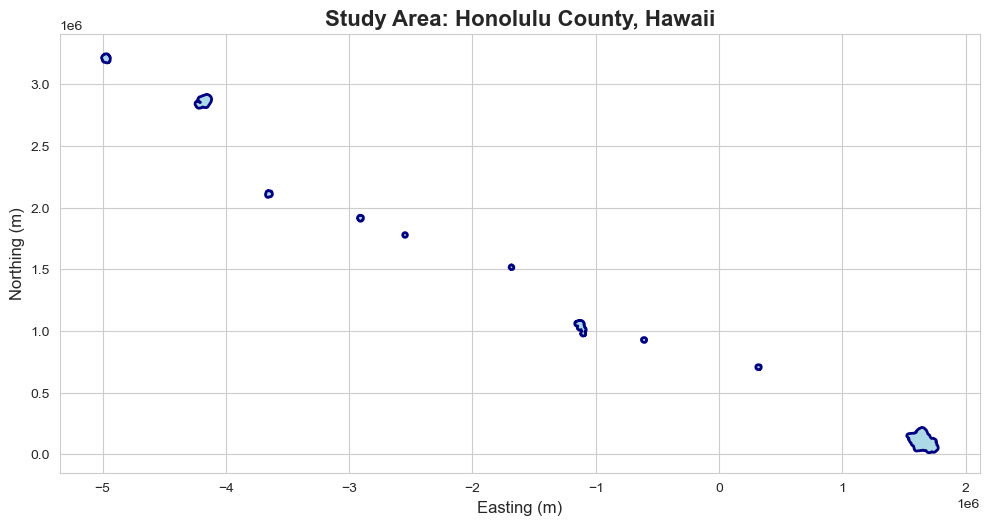

✓ Study area bounds: [-5007795.82807378    11870.19523467  1777498.79143474  3246934.66955564]


In [5]:
# Visualize Honolulu County boundary
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
honolulu.plot(ax=ax, facecolor='lightblue', edgecolor='navy', linewidth=2)
ax.set_title('Study Area: Honolulu County, Hawaii', fontsize=16, fontweight='bold')
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)
plt.tight_layout()
plt.savefig('outputs/figures/01_study_area.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Study area bounds: {honolulu.total_bounds}")

In [6]:
# Load waterways
print("Loading waterways...")
waterways = gpd.read_file(RAW_DATA['waterways'])
print(f"  Loaded {len(waterways)} waterway features")
print(f"  Original CRS: {waterways.crs}")

# Reproject and clip to Honolulu
waterways = waterways.to_crs(TARGET_CRS)
waterways_honolulu = gpd.clip(waterways, honolulu)
print(f"✓ Clipped to Honolulu: {len(waterways_honolulu)} features remaining")

# Save processed waterways
waterways_honolulu.to_file('data/processed/waterways_honolulu.shp')
print("✓ Saved: data/processed/waterways_honolulu.shp")

Loading waterways...
  Loaded 10785 waterway features
  Original CRS: EPSG:3750
✓ Clipped to Honolulu: 2340 features remaining
✓ Saved: data/processed/waterways_honolulu.shp


In [7]:
# Load lines (assuming these are coastlines or additional water features)
print("Loading lines...")
lines = gpd.read_file(RAW_DATA['lines'])
print(f"  Loaded {len(lines)} line features")
print(f"  Original CRS: {lines.crs}")

# Reproject and clip to Honolulu
lines = lines.to_crs(TARGET_CRS)
lines_honolulu = gpd.clip(lines, honolulu)
print(f"✓ Clipped to Honolulu: {len(lines_honolulu)} features remaining")

# Save processed lines
lines_honolulu.to_file('data/processed/lines_honolulu.shp')
print("✓ Saved: data/processed/lines_honolulu.shp")

Loading lines...
  Loaded 13 line features
  Original CRS: EPSG:3750
✓ Clipped to Honolulu: 4 features remaining
✓ Saved: data/processed/lines_honolulu.shp


In [8]:
# Load census block groups
print("Loading census block groups...")
census_bg = gpd.read_file(RAW_DATA['census_bg'])
print(f"  Loaded {len(census_bg)} block groups")
print(f"  Original CRS: {census_bg.crs}")

# Filter for Honolulu County (COUNTYFP == '003')
census_bg_honolulu = census_bg[census_bg['COUNTYFP'] == '003'].copy()
print(f"✓ Filtered to Honolulu: {len(census_bg_honolulu)} block groups")

# Reproject to target CRS
census_bg_honolulu = census_bg_honolulu.to_crs(TARGET_CRS)
print(f"✓ Reprojected to {TARGET_CRS}")

# Display available columns
print("\nAvailable census columns:")
print(census_bg_honolulu.columns.tolist())

# Save processed census data
census_bg_honolulu.to_file('data/processed/census_bg_honolulu.shp')
print("✓ Saved: data/processed/census_bg_honolulu.shp")

Loading census block groups...
  Loaded 1083 block groups
  Original CRS: EPSG:4269
✓ Filtered to Honolulu: 774 block groups
✓ Reprojected to EPSG:3759

Available census columns:
['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']
✓ Saved: data/processed/census_bg_honolulu.shp


In [9]:
print("IMPORTANT: You need to add population data")
print("Options:")
print("1. Download ACS 2020 5-year estimates from data.census.gov")
print("2. Use tidycensus in R or censusdata in Python")
print("3. Manually join population data to census_bg_honolulu")


)
np.random.seed(42)
census_bg_honolulu['total_population'] = np.random.randint(500, 5000, len(census_bg_honolulu))
print("⚠️ Using synthetic population data for demonstration")
print(f"✓ Total population (synthetic): {census_bg_honolulu['total_population'].sum():,}")

⚠️ IMPORTANT: You need to add population data
Options:
1. Download ACS 2020 5-year estimates from data.census.gov
2. Use tidycensus in R or censusdata in Python
3. Manually join population data to census_bg_honolulu
⚠️ Using synthetic population data for demonstration
✓ Total population (synthetic): 2,163,336


In [10]:
# Load and process DEM
print("Loading DEM...")
with rasterio.open(RAW_DATA['dem']) as src:
    print(f"  DEM CRS: {src.crs}")
    print(f"  DEM shape: {src.shape}")
    print(f"  DEM resolution: {src.res}")
    print(f"  DEM bounds: {src.bounds}")
    
    # Reproject Honolulu boundary to DEM CRS for clipping
    honolulu_dem_crs = honolulu.to_crs(src.crs)
    
    # Clip DEM to Honolulu boundary
    geom = [honolulu_dem_crs.geometry.values[0]]
    out_image, out_transform = mask(src, geom, crop=True, nodata=-9999)
    out_meta = src.meta.copy()
    
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": -9999
    })

# Save clipped DEM in original CRS
clipped_dem_path = 'data/processed/dem_honolulu_original_crs.tif'
with rasterio.open(clipped_dem_path, 'w', **out_meta) as dest:
    dest.write(out_image)

print(f"✓ Clipped DEM saved: {clipped_dem_path}")

Loading DEM...
  DEM CRS: EPSG:3750
  DEM shape: (52328, 67407)
  DEM resolution: (1.0, 1.0)
  DEM bounds: BoundingBox(left=573085.9947693374, bottom=2350512.550161029, right=640492.9947693374, top=2402840.550161029)
✓ Clipped DEM saved: data/processed/dem_honolulu_original_crs.tif


In [11]:
# Reproject DEM to target CRS (EPSG:3759)
print(f"Reprojecting DEM to {TARGET_CRS}...")

with rasterio.open(clipped_dem_path) as src:
    # Calculate optimal transform and dimensions
    transform, width, height = calculate_default_transform(
        src.crs, TARGET_CRS, src.width, src.height, *src.bounds
    )
    
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': TARGET_CRS,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Reproject and save
    reprojected_dem_path = 'data/processed/dem_honolulu.tif'
    with rasterio.open(reprojected_dem_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=TARGET_CRS,
                resampling=Resampling.bilinear
            )

print(f"✓ Reprojected DEM saved: {reprojected_dem_path}")

# Verify reprojected DEM
with rasterio.open(reprojected_dem_path) as src:
    print(f"  Final CRS: {src.crs}")
    print(f"  Final shape: {src.shape}")
    print(f"  Final resolution: {src.res}")

Reprojecting DEM to EPSG:3759...
✓ Reprojected DEM saved: data/processed/dem_honolulu.tif
  Final CRS: EPSG:3759
  Final shape: (52758, 67740)
  Final resolution: (3.281650196067137, 3.281650196067137)


MemoryError: Unable to allocate 13.3 GiB for an array with shape (3573826920,) and data type float32

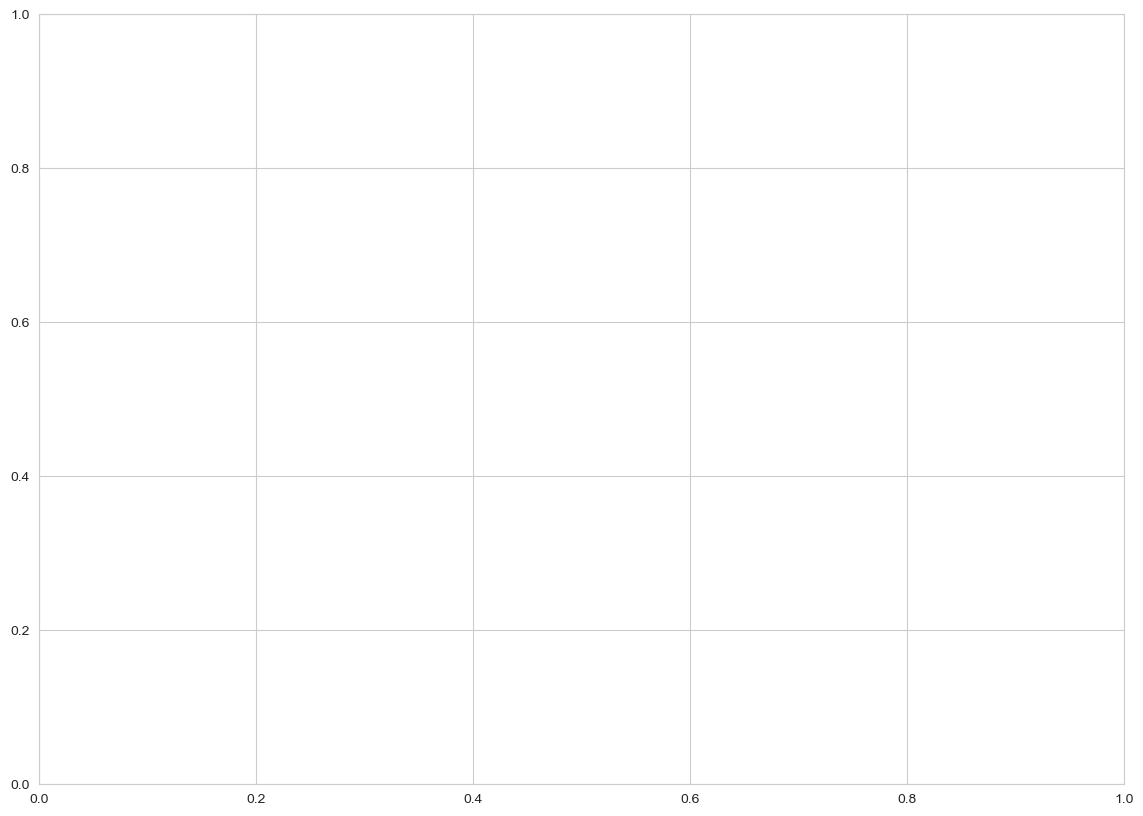

In [12]:
# Create comprehensive visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Plot DEM
with rasterio.open(reprojected_dem_path) as src:
    dem_data = src.read(1)
    dem_data = np.where(dem_data == -9999, np.nan, dem_data)
    
    from rasterio.plot import show
    show(dem_data, transform=src.transform, ax=ax, cmap='terrain', 
         vmin=0, vmax=np.nanpercentile(dem_data, 99))

# Overlay vector data
waterways_honolulu.plot(ax=ax, color='blue', linewidth=1, alpha=0.6, label='Waterways')
lines_honolulu.plot(ax=ax, color='darkblue', linewidth=2, alpha=0.8, label='Coastline/Lines')
census_bg_honolulu.boundary.plot(ax=ax, color='red', linewidth=0.5, alpha=0.5, label='Census Block Groups')
honolulu.boundary.plot(ax=ax, color='black', linewidth=3, label='County Boundary')

ax.set_title('Honolulu County: Processed Spatial Data', fontsize=16, fontweight='bold')
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('outputs/figures/02_all_processed_data.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Data preprocessing complete!")

In [13]:
# Generate summary statistics
print("="*60)
print("DATA PREPROCESSING SUMMARY")
print("="*60)

print(f"\n📍 Study Area: Honolulu County")
print(f"   CRS: {TARGET_CRS}")
print(f"   Area: {honolulu.geometry.area.values[0]/1e6:.2f} km²")

print(f"\n Waterways:")
print(f"   Features: {len(waterways_honolulu)}")
print(f"   Total length: {waterways_honolulu.length.sum()/1000:.2f} km")

print(f"\n Lines/Coastline:")
print(f"   Features: {len(lines_honolulu)}")
print(f"   Total length: {lines_honolulu.length.sum()/1000:.2f} km")

print(f"\n Census Block Groups:")
print(f"   Count: {len(census_bg_honolulu)}")
print(f"   Total population: {census_bg_honolulu['total_population'].sum():,}")
print(f"   Avg population per BG: {census_bg_honolulu['total_population'].mean():.0f}")

with rasterio.open(reprojected_dem_path) as src:
    dem_data = src.read(1)
    dem_data = dem_data[dem_data != -9999]
    
    print(f"\n Digital Elevation Model:")
    print(f"   Resolution: {src.res[0]:.1f}m × {src.res[1]:.1f}m")
    print(f"   Dimensions: {src.shape[0]} × {src.shape[1]} pixels")
    print(f"   Elevation range: {dem_data.min():.1f}m to {dem_data.max():.1f}m")
    print(f"   Mean elevation: {dem_data.mean():.1f}m")

print("\n✓ All data successfully preprocessed and ready for analysis")
print("="*60)

DATA PREPROCESSING SUMMARY

📍 Study Area: Honolulu County
   CRS: EPSG:3759
   Area: 61973.65 km²

🌊 Waterways:
   Features: 2340
   Total length: 7849.08 km

🏖️ Lines/Coastline:
   Features: 4
   Total length: 1316.63 km

🏘️ Census Block Groups:
   Count: 774
   Total population: 2,163,336
   Avg population per BG: 2795


MemoryError: Unable to allocate 13.3 GiB for an array with shape (1, 52758, 67740) and data type float32